In [1]:
%matplotlib inline
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,explained_variance_score
import time
from datetime import timedelta
import math
import pickle
import pandas
from datapipe import bin_ndarray
from skimage import io

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model, Model
from keras.layers import BatchNormalization, Input, Dense, Flatten, GlobalAveragePooling2D, Conv1D,Conv2D, MaxPooling2D,MaxPooling1D, Dropout, UpSampling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
def bin_dy(dy):
    (length, y, x) = dy.shape
    print(dy.shape)
    newdy = np.zeros((length, int(y/2), int(x/2)), dtype=np.float16)
    for ind, image in enumerate(dy):
        newdy[ind] = bin_ndarray(image, (int(y/2), int(x/2)))
    # newdyfile = open('./dfy/bin_AV_2.pkl', 'wb')
    print(newdy.shape)
    return newdy

In [23]:
def cropImage(imArr):
    (length, x, y, channel) = imArr.shape
    cropped = np.zeros((length, x+1, y, channel))
    for ind, im in enumerate(imArr):
        for rowind, row in enumerate(im):
            if not rowind == 0: 
                cropped[ind][rowind-1] = row
    return cropped
            

In [5]:
# whisk = io.imread('./data/fullvid_av2.tif')
whisk = np.load('./data/dffAV_2.npy', mmap_mode='r')
np.random.seed(42)
(length, lenx, leny) = whisk.shape
print(whisk.shape)
print(lenx,leny)

(54000, 319, 320)
319 320


In [41]:
diffwhisk = np.zeros(whisk.shape, dtype=np.float32)
tempim = np.zeros((lenx,leny), dtype=np.float32)
for imInd, im in enumerate(whisk):
    diffwhisk[imInd] = np.abs(np.subtract(tempim, im))
    tempim = im

In [42]:
print(diffwhisk)

[[[1.13647461e-01 2.95410156e-02 2.47955322e-02 ... 7.33642578e-02
   7.43408203e-02 7.76367188e-02]
  [5.34362793e-02 2.24304199e-02 1.96838379e-02 ... 1.01562500e-01
   9.64355469e-02 8.31298828e-02]
  [3.46679688e-02 3.66516113e-02 1.73187256e-02 ... 7.49511719e-02
   8.49609375e-02 5.88989258e-02]
  ...
  [8.45947266e-02 7.01904297e-02 6.54296875e-02 ... 1.32568359e-01
   1.33056641e-01 1.24511719e-01]
  [9.19189453e-02 8.75244141e-02 7.65991211e-02 ... 1.16333008e-01
   1.34033203e-01 1.26342773e-01]
  [8.41064453e-02 7.84301758e-02 7.78808594e-02 ... 1.28906250e-01
   1.33056641e-01 1.82128906e-01]]

 [[4.02832031e-03 1.00097656e-02 2.73132324e-03 ... 5.18798828e-03
   4.76074219e-03 1.83105469e-03]
  [9.30786133e-03 2.19726562e-03 1.09863281e-03 ... 6.34765625e-03
   3.84521484e-03 2.74658203e-03]
  [3.60107422e-03 1.82342529e-02 6.37817383e-03 ... 7.32421875e-03
   1.58691406e-03 1.83715820e-02]
  ...
  [1.05590820e-02 3.66210938e-04 7.93457031e-04 ... 7.62939453e-03
   5.73730

In [6]:
def crop(imArr):
    (length, x, y) = imArr.shape
    cropped = np.zeros((length, x+1, y), dtype=np.uint8)
    for ind, im in enumerate(imArr):
        for rowind, row in enumerate(im):
            if not rowind == 0: 
                cropped[ind][rowind-1] = row
    return cropped

In [43]:
# data = bin_dy(crop(whisk))
data =whisk.astype(np.float64)

In [44]:
# print(data.shape)
# np.save('./data/binnedfull_av2.npy', data)

In [45]:
num_data = len(data)
train_split = 0.7
validation_split = 0.1
num_train = int(train_split*num_data)
num_val = int((num_data - num_train)*validation_split)
num_test = num_data - num_train - num_val
x_train = data[0:num_train].reshape(num_train, (lenx*leny))
x_test = data[(num_train):].reshape(num_test+num_val, (lenx*leny))

In [46]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [47]:
x_test_scaled = x_scaler.transform(x_test)

In [48]:
input_img = Input(shape=(lenx+1, leny, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (2, 2), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(16, (2, 2), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (2, 2), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [49]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 320, 320, 1)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 320, 320, 32)      160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 160, 160, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 160, 160, 16)      2064      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 80, 80, 16)        1040      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 40, 40, 16)        0         
__________

In [50]:
print(lenx,leny)
x_train = x_train_scaled.reshape((num_train, lenx,leny,1))
x_test = x_test_scaled.reshape((num_test+num_val, lenx, leny, 1))
print(x_test.shape)
x_train = cropImage(x_train.astype(np.float32))
x_test = cropImage(x_test.astype(np.float32))
print(x_test.shape)

319 320
(16200, 319, 320, 1)
(16200, 320, 320, 1)


In [51]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [52]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [53]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [54]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [55]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]
print(x_train.shape)

(37800, 320, 320, 1)


In [56]:
%%time
autoencoder.fit(x_train, x_train,
                epochs=12,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)

Train on 37800 samples, validate on 16200 samples
Epoch 1/12
37800/37800 [==============================] - 560s 15ms/step - loss: 0.6556 - val_loss: 0.6376

Epoch 00001: val_loss improved from inf to 0.63757, saving model to 23_checkpoint.keras
Epoch 2/12
37800/37800 [==============================] - 563s 15ms/step - loss: 0.6476 - val_loss: 0.6343

Epoch 00002: val_loss improved from 0.63757 to 0.63427, saving model to 23_checkpoint.keras
Epoch 3/12
12864/37800 [=========>....................] - ETA: 5:24 - loss: 0.6451

KeyboardInterrupt: 

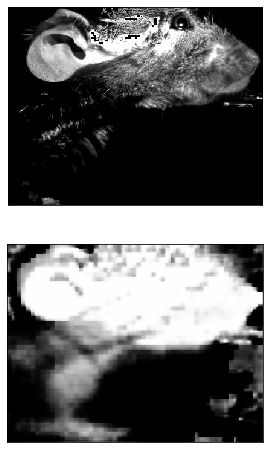

In [31]:
decoded_imgs = full_decoder.predict(predictions)

n = 1
plt.figure(figsize=(40, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_scaled[i].astype(np.float32).reshape(lenx, leny))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(lenx, leny+2))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [51]:
autoencoder.save('fullEncoder2.h5')

In [6]:
autoencoder = load_model('fullEncoder2.h5')
predictions = np.load("statePredictions.npy")

In [7]:
input_img = Input(shape=(41, 53, 8)) 
e_l  = autoencoder.layers[7]
e_l1 = autoencoder.layers[8]
e_l2 = autoencoder.layers[9]
e_l3 = autoencoder.layers[10]
e_l4 = autoencoder.layers[11]
e_l5 = autoencoder.layers[12]
e_l6 = autoencoder.layers[13]
full_decoder = Model(input_img, e_l6(e_l5(e_l4(e_l3(e_l2(e_l1(e_l(input_img))))))))

In [11]:
predictions.shape

(1, 2000, 17384)

In [13]:
other, length, x = predictions.shape
predictions = predictions.reshape(length, 41,53,8)